# generatingFakeReadsForTesting.ipynb
## Marcus Viscardi,    September 02, 2022

I want to try and do some simple read generation with just text "parsing" and the expected read sequences

The main goal would be to make a simple function that could take an expected read sequence identity and then spit out a crapload of altered reads that could be used for testing and such!

In [1]:
import mappy
import mappy as mp
from pprint import pprint
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Union, List
import random
from nanoporePipelineCommon import find_newest_matching_file, pick_libs_return_paths_dict, get_dt
import textwrap

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", None)
print("imports done")

imports done


### Load the standards fasta file into a dictionary:

In [2]:
reference_fasta = "/data16/marcus/scripts/nanoporePipelineScripts/standardsAlignment/220902_version2.0_releventSequences.fasta"

finalStandards_dict = {}
for read_id, sequence, quality, comments in mp.fastx_read(reference_fasta, read_comment=True):
    if "finalStandard" in read_id:
        finalStandards_dict[read_id] = (sequence, comments)

### Create methods for generating fake reads and plotting mappy alignments

In [3]:
def sequence_subindel_creater(seq,
                              insert_prob=0.01,
                              delete_prob=0.01,
                              sub_prob=0.05,
                              indel_size_factor=1.0) -> str:
    # TODO: Add ability to output multiple sequences
    # TODO: Add adjustable propensity to truncate reads!
    seq = seq.upper()
    adjusted_seq = ""
    choices_per_nt = {"insert": insert_prob,
                      "delete": delete_prob,
                      "substitute": sub_prob,
                      "nothing": 1 - (insert_prob + delete_prob + sub_prob)}
    # For now, we'll just do single nucleotide indels
    indel_sizes = [i+1 for i in range(25)]
    indel_weights = [10**((indel_size_factor * -i)+1) for i in range(25)]
    # print("Setting up:", indel_sizes, indel_weights)
    nucleotide_choices = ['G', 'C', 'T', 'A']
    
    index = 0
    while index < len(seq):
        nucl = seq[index]
        choice = random.choices(list(choices_per_nt.keys()), weights=list(choices_per_nt.values()))[0]
        if choice == "insert":
            index += 1
            indel_size = random.choices(indel_sizes, weights=indel_weights)[0]
            for _ in range(indel_size):
                nucl += random.choice(nucleotide_choices)
        elif choice == "substitute":
            index += 1
            nucl = random.choice(nucleotide_choices)
        elif choice == 'delete':
            indel_size = random.choices(indel_sizes, weights=indel_weights)[0]
            index += indel_size
            nucl = ''
        else:
            index += 1
        adjusted_seq += nucl
    return adjusted_seq


def print_mappy_hit_alignment(mappy_hit_obj: mappy.Alignment,
                              read_seq: str, ref_seq: str,
                              line_print_width=None) -> None:
    import re
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', mappy_hit_obj.cigar_str)
    parsed_cigar = [(int(num), char) for num, char in parsed_cigar]
    ref_seq = ref_seq[mappy_hit_obj.r_st: mappy_hit_obj.r_en]
    ref_pos = 0
    read_seq = read_seq[mappy_hit_obj.q_st: mappy_hit_obj.q_en]
    read_pos = 0
    
    top_line = ""
    middle_line = ""
    bottom_line = ""
    for length, code in parsed_cigar:
        if code == "M":  # Map (Read & Ref Match)
            read_map_piece = read_seq[read_pos:read_pos+length]
            ref_map_piece = ref_seq[ref_pos:ref_pos+length]
            perfect_matches = ""
            for index, char in enumerate(read_map_piece):
                try:
                    if char == ref_map_piece[index]:
                        perfect_matches += "|"
                    else:
                        perfect_matches += "•"
                except IndexError:
                    perfect_matches += " "
            top_line += read_map_piece
            middle_line += perfect_matches
            bottom_line += ref_map_piece
            ref_pos += length
            read_pos += length
        elif code == "I":  # Insert (Gap in Ref)
            top_line += read_seq[read_pos:read_pos+length]
            middle_line += " " * length
            bottom_line += " " * length
            read_pos += length
        elif code == "D" or code == "N":  # Delete (Gap in Read)
            top_line += " " * length
            middle_line += " " * length
            bottom_line += ref_seq[ref_pos:ref_pos+length]
            ref_pos += length
    if isinstance(line_print_width, int):
        num_blocks = int(np.ceil(len(top_line) / line_print_width))
        print_blocks = []
        for block_index in range(num_blocks):
            print_blocks.append([
                top_line[block_index*line_print_width:(block_index+1)*line_print_width],
                middle_line[block_index*line_print_width:(block_index+1)*line_print_width],
                bottom_line[block_index*line_print_width:(block_index+1)*line_print_width],
            ])
        for top, mid, bot in print_blocks:
            print()
            print(f"Read: {top}")
            print(f"      {mid}")
            print(f"Ref:  {bot}")
    else:
        print(top_line, middle_line, bottom_line, sep='\n')

### A loop to test out mapping the generated reads from the standards

100%|██████████| 10/10 [00:00<00:00, 485.96it/s]

{-1: 0, 0: 0, 5: 0, 10: 0, 15: 0, 30: 10, 60: 0}


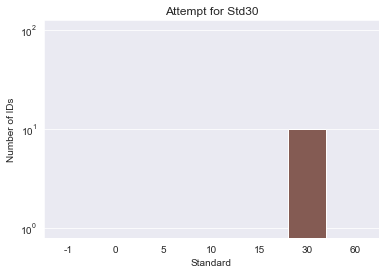

In [4]:
aligner = mp.Aligner("/data16/marcus/scripts/nanoporePipelineScripts/standardsAlignment/220902_version2.0_releventSequences.fasta", preset="map-ont")

# Change these values to effect the run:
########################################
tail_length_of_fake_standard = 30
standard_to_fake = f"ENO2_finalStandard_{tail_length_of_fake_standard:0>2}Tail"
quiet = True
number_of_iterations = 10
insert_prob_quick, delete_prob_quick, sub_prob_quick = 0.025, 0.025, 0.05
indel_size_factor_quick = 1
# ^This is inversely related to the propensity for larger and larger indels!
########################################

generated_seq_identification = {-1:0,  # For any completely unmapped
                                0:0,
                                5:0,
                                10:0,
                                15:0,
                                30:0,
                                60:0,}
iterator = tqdm(range(number_of_iterations))
for i in iterator:
    if not quiet:
        print(f"Generated Standard #{i+1:0>2}:")
    generated_seq = sequence_subindel_creater(finalStandards_dict[standard_to_fake][0], 
                                              insert_prob=insert_prob_quick,
                                              delete_prob=delete_prob_quick,
                                              sub_prob=sub_prob_quick,
                                              indel_size_factor=indel_size_factor_quick)[:]
    hits = {hit: (hit.ctg, hit.is_primary) for hit in aligner.map(generated_seq)}
    if len(hits) == 0:
        if not quiet:
            print("No hits")
        generated_seq_identification[-1] += 1
    for hit_obj, (contig, is_primary) in hits.items():
        if hit_obj.ctg != standard_to_fake and hit_obj.is_primary == 1:
            contig_hit = int(hit_obj.ctg[19:21])
            generated_seq_identification[contig_hit] += 1
            if not quiet:
                print(f"Primary: {int(hit_obj.is_primary)}, MAPQ: {hit_obj.mapq:>2}, Mismatches: {hit_obj.NM:>2}, Maps: {hit_obj.mlen:>2}, Contig: {contig_hit}nt Tail")
                print_mappy_hit_alignment(hit_obj, generated_seq, aligner.seq(hit_obj.ctg), line_print_width=50)
            for hit_obj, (contig, is_primary) in hits.items():
                contig_hit = int(hit_obj.ctg[19:21])
                if not quiet:
                    print(f"Primary: {int(hit_obj.is_primary)}, MAPQ: {hit_obj.mapq:>2}, Mismatches: {hit_obj.NM:>2}, Maps: {hit_obj.mlen:>2}, Contig: {contig_hit}nt Tail")
                if contig == standard_to_fake and not quiet:
                    pass # print_mappy_hit_alignment(hit_obj, generated_seq, aligner.seq(hit_obj.ctg), line_print_width=50)
        elif hit_obj.ctg == standard_to_fake and hit_obj.is_primary == 1:
            contig_hit = int(hit_obj.ctg[19:21])
            generated_seq_identification[contig_hit] += 1
            if not quiet:
                print("\tAccurate Match.")
pprint(generated_seq_identification)
# x_and_y = [(str(key), value) for key, value in generated_seq_identification.items()]
# x, y = zip(*x_and_y)
# ended up note using the above code, but I thought it was a cute solution
my_df = pd.DataFrame(generated_seq_identification.items())
ax = sea.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Standard', ylabel='Number of IDs', title=f'Attempt for Std{standard_to_fake[19:21]}',
       yscale='log')
plt.show()

### Build a fasta file of reads generated off of the standards, with the original standard sequence as the title (plus some kind of UMI or counter)

In [39]:
# Change these values to effect the generated fasta:
####################################################
standards_to_use = [0, 5, 10, 15, 30, 60]
number_of_entries_in_fasta = 1000
insert_prob_quick, delete_prob_quick, sub_prob_quick = 0.01, 0.01, 0.05
indel_size_factor_quick = 1
output_file_name = f"{get_dt(for_file=True)}_generatedRNAStdsReads.fasta"
save_output = True
# ^This is inversely related to the propensity for larger and larger indels!
####################################################

fasta_storage_dict = {}
iterator = tqdm(range(number_of_entries_in_fasta))
with open(output_file_name, 'w') as output_fasta:
    for i in iterator:
        template_standard_size = random.choice(standards_to_use)
        template_standard = f"ENO2_finalStandard_{template_standard_size:0>2}Tail"
        entry_num = f"{i+1:0>{1+int(np.ceil(np.log10(number_of_entries_in_fasta)))}}"
        generated_seq = sequence_subindel_creater(finalStandards_dict[template_standard][0], 
                                                  insert_prob=insert_prob_quick,
                                                  delete_prob=delete_prob_quick,
                                                  sub_prob=sub_prob_quick,
                                                  indel_size_factor=indel_size_factor_quick)[:]
        seq_id = f"RNAStd{template_standard_size:0>2}.N{entry_num} template={template_standard} entry_number={entry_num}"
        fasta_storage_dict[seq_id] = generated_seq
        file_line = f">{seq_id}\n{textwrap.fill(generated_seq, width=5000)}\n"
        if save_output:
            output_fasta.write(file_line)
        else:
            print(file_line)


100%|██████████| 1000/1000 [00:01<00:00, 892.76it/s]


#### **Next step will be to use the old standard mapping functions to see if we can get them to work with this fake data and the new standards format as designed with Levenshtein distances!**

# This below text block uses the old system of deciding out to assign standards reads to their barcodes
## The main problem with this is that **A LOT** of the old system was hardcoded for specific features of the old standard design
## I have been wresting with the idea of trying to adjust all this code to the new standards or just completely rewriting it. I am inclined to rewrite:
While I do like a lot of the code that I wrote for the old one, I think the whole thing was mostly built up piecewise, rather than actually being purpose built from the beginning.
*Also*, it would be nice to make the whole system a lot more legible!

In [26]:
# from standardsAlignment.early2022versions.standardsAssignmentWithMinimap2 import align_standards
# Copying these over, so I can mess with them a bit!
def align_standards(fastq_file=None, compressed_df=None, keep_read_id=False, bar_width=None,
                    keep_minimap_obj=False, threads=10, tail_less_reference=False,
                    specified_reference=None,
                    **kwargs) -> Union[str, pd.DataFrame]:
    if isinstance(specified_reference, str):
        path_to_genome = specified_reference
    elif tail_less_reference:  # This ref doesn't have the tails or HDV attached to the 3' ends
        path_to_genome = "/data16/marcus/genomes/plus-pTRIxef_elegansRelease100/" \
                         "intermediate_files/standards_with_indexes_without_tails_or_HDV.fa"
    else:  # This ref does...
        path_to_genome = "/data16/marcus/genomes/plus-pTRIxef_elegansRelease100/" \
                         "intermediate_files/standards_with_indexes.fa"
    aligner = mp.Aligner(path_to_genome,
                         preset="splice", k=14,  # These are the usual go-tos for mapping ONT dRNA-Seq
                         extra_flags=0x100000,  # From: https://github.com/lh3/minimap2/blob/master/minimap.h
                         #           0x100000 = forces strand matched alignment (b/c dRNA-seq retains strand info)
                         n_threads=threads,
                         )
    if not aligner:
        raise Exception("ERROR: failed to load/build index")  # This was in the tutorial, haven't seen this yet.

    # Print the contigs (chromosomes) which in this case are the adapters in the fastq
    print(f"Mapping to adapters named: {aligner.seq_names}")

    seq_assignments = []  # This list will hold all the alignments eventually

    # This method optionally takes a fastq file OR a compressed dataframe.
    #   The method will throw an error if neither are given.

    # If a fastq file is passed:
    if isinstance(fastq_file, str):
        # Create a tqdm iterator that is going to loop through the fastq,
        #   and provide a progress bar along the way!
        if fastq_file.endswith("q"):
            lines_per_entry = 4
        elif fastq_file.endswith("a"):
            lines_per_entry = 2
        else:
            raise NotImplementedError(f"The input fastx file must end in fastq/fq or fasta/fa!!")
        read_iterator = tqdm(mp.fastx_read(fastq_file),
                             # The Mappy library (from Minimap2) has a fastx file reader that is very fast
                             total=sum(1 for line in open(fastq_file)) // lines_per_entry,
                             # The mappy.fastx_read iterator doesn't have a __len__, so we
                             #    have to manually tell tqdm how long the fastq will be
                             ncols=bar_width)
        for read_id, sequence, _ in read_iterator:
            seq_assignment = _loop_align_seq_to_adapters(aligner,
                                                         read_id,
                                                         sequence,
                                                         keep_read_id=keep_read_id,
                                                         was_fastq=True,
                                                         **kwargs)
            # Save the assignment dictionary from the aligner loop into the list:
            seq_assignments.append(seq_assignment)
            # Set the progress bar description, mostly cuz it's fun...
            read_iterator.set_description(f"Processing {read_id}")

    # if a compressed on reads dataframe is passed:
    elif isinstance(compressed_df, pd.DataFrame):
        print(f"Not implemented here, look in the script standardsAssignmentWithMinimap2.py!!")
    else:
        raise NotImplementedError("Please provide either a fastq or a df")

    print("Finished Alignment")

    mappy_df = pd.DataFrame(seq_assignments)

    if not keep_minimap_obj:
        # These columns will be extracted from the mapping object:
        mappy_cols = ["stds_q_start",
                      "stds_q_end",
                      "stds_strand",
                      "stds_chr_id",
                      "stds_chr_len",
                      "stds_r_start",
                      "stds_r_end",
                      "stds_mlen",
                      "stds_blen",
                      "stds_mapq",
                      "stds_type_of_alignment",
                      "stds_ts",
                      "stds_cigar",
                      ]

        # Loop to extract and drop the mappy python object
        mappy_df[mappy_cols] = mappy_df.apply(lambda row:
                                              _loop_pull_mappy_obj_info(row["mapping_obj"],
                                                                        columns=mappy_cols),
                                              axis=1, result_type="expand")
        mappy_df.drop(columns="mapping_obj", inplace=True)

        # Extract the last bit of information stored in the mappy flags
        for mappy_flag_col in ["stds_type_of_alignment", "stds_ts", "stds_cigar"]:
            mappy_df[mappy_flag_col] = mappy_df[mappy_flag_col].str.split(":").str[-1]
    return mappy_df


def _loop_align_seq_to_adapters(aligner, read_id, sequence, chr_id=None,
                                print_per_seq=False, print_per_seq_plus=False,
                                keep_read_id=False, was_fastq=False,
                                print_stuff=False, **kwargs):
    # This will quickly filter out those reads that didn't initially map to the pTRI chr
    if not was_fastq and chr_id != "pTRI":
        seq_assignment = {"adapter": "not_pTRI_standard", "mapping_obj": None}
        if keep_read_id:
            seq_assignment["read_id"] = read_id
        return seq_assignment

    if print_per_seq:
        print(f"Aligning read: {read_id}", end="\t")

    # For each sequence, create empty dicts to store info about mapping hits
    hit_objs = {}

    # Loop through each of the mapping hits generated:
    for hit in aligner.map(sequence):
        hit_objs[hit.ctg] = hit  # and store each one

    # If1: there are any mapping hits:
    if hit_objs:

        # If2: all the hits are not the same  M-length! (would be the same if they all
        #     had mapped to non-unique areas <- i.e. not the index region)
        hit_matches = {k: hit.mlen for k, hit in hit_objs.items()}  # count the number of Ms for each map
        if len(set(hit_matches.values())) > 1:
            # Find and store the longest map:
            max_match = max(hit_matches.values())
            # Make a list of hits that match the longest map:
            max_match_keys = [k for k, v in hit_matches.items() if v == max_match]

            # If3: there is only one longest mapping hit:
            if len(max_match_keys) == 1:
                # It wins, store it.
                seq_assignment = {"adapter": max_match_keys[0],
                                  "mapping_obj": hit_objs[max_match_keys[0]]}
                if keep_read_id:
                    seq_assignment["read_id"] = read_id
                if print_per_seq:
                    print(seq_assignment)
                    read_end = seq_assignment["mapping_obj"].q_en
                    print(sequence[read_end - 10:read_end + 2], read_end)

            # Else3: There is more than 1 longer mapping hit.
            #        i.e. Two indexes have the same number of Ms inside
            else:
                # Check if any of the hits map out to the index in chr space:
                if max([hit.r_en for k, hit in hit_objs.items()]) < 1452:
                    # If none due, I assume the read wasn't long enough (BAD ASSUMPTION)
                    seq_assignment = {"adapter": "ambiguous_subset_too_short",
                                      "mapping_obj": None}
                    if print_per_seq:
                        print("Ambiguous, subset of adapters too short")
                # Otherwise, it's likely the example case for If-Else loop #3
                else:
                    index_matches = {}

                    # For each map hit we'll make a string that matches in length w/ the ref chr:
                    for std, hit in hit_objs.items():

                        # Create variables to store info to for each map hit
                        map_seq = ''  # This will hold the gaped read sequence
                        temp_seq = sequence[hit.q_st:]  # Start the sequence at the first mapped base
                        ref = aligner.seq(hit.ctg)  # Start the reference at the first mapped base
                        alignment = ''  # This will hold pipes or spaces to match with M's from the CIGAR

                        # Loop through the cigar string, walking along the sequence and reference along the way:
                        for cig_count, cig_type in hit.cigar:

                            # IF the cigar tag is a map, walk same distance in both seq and ref
                            if cig_type == 0:  # (M)apped
                                map_seq += temp_seq[:cig_count]
                                temp_seq = temp_seq[cig_count:]
                                alignment += '|' * cig_count  # and add matches to th alignment
                            # IF the cigar tag is a deletion or intron, add spacers to the sequence
                            elif cig_type == 2 or cig_type == 3:  # (D)eletion or i(N)tron
                                map_seq += '.' * cig_count
                                alignment += ' ' * cig_count  # and add misses to the alignment
                            # IF the cigar tag is an insertion, only walk along the reference
                            elif cig_type == 1:  # (I)nsertion
                                temp_seq = temp_seq[cig_count:]
                            # Otherwise, catch any cases with other cigar tags (I should have any?)
                            else:
                                raise NotImplementedError(f"Unexpected code in cigar string: [{cig_count}, {cig_type}]")
                        if print_per_seq_plus:
                            print('\n' + hit.ctg + ':\t' + read_id + '\tMaps:' + str(hit.mlen))
                            print(f"  ref_start: {hit.r_st:>3};\t  ref_end: {hit.r_en:>3}\n"
                                  f"query_start: {hit.q_st:>3};\tquery_end: {hit.q_en:>3}")
                            print(ref[hit.r_st:], alignment, map_seq, sep='\n')

                        # I can't decide between keeping or ignoring the flanking CTCT's
                        # W/ CTCT flanking region
                        # umi_region_ref = ref[1452:1452+16]
                        # umi_region_alignment = alignment[1452-hit.r_st:1452-hit.r_st+16]
                        # umi_region_query = map_seq[1452-hit.r_st:1452-hit.r_st+16]

                        # W/out CTCT flanking region
                        umi_region_ref = ref[1456:1456 + 8]
                        umi_region_alignment = alignment[1456 - hit.r_st:1456 - hit.r_st + 8]
                        umi_region_query = map_seq[1456 - hit.r_st:1456 - hit.r_st + 8]

                        # Make a short list of 1's for matched nucleotides and 0's for mismatched:
                        umi_region_matches = [1 if x == y else 0 for x, y in zip(umi_region_ref, umi_region_query)]
                        # Count number of matches (1's):
                        umi_region_match_count = sum(umi_region_matches)
                        # Store that count in the original dictionary from way earlier:
                        index_matches[std] = umi_region_match_count

                        if print_stuff:
                            if len(umi_region_query) >= 2:
                                print(umi_region_ref,
                                      umi_region_alignment,
                                      umi_region_query,
                                      ''.join(map(str, umi_region_matches)),
                                      f"Match sum: {sum(umi_region_matches)}",
                                      sep='\n')
                                print('\n')
                            else:
                                print(umi_region_ref,
                                      f"*Too Short Match",
                                      sep='\n')
                    # Figure out the best UMI match we saw:
                    max_index_match = max(index_matches.values())
                    # Again, make a list of the one or multiple best match(es):
                    max_index_match_keys = [k for k, v in index_matches.items() if v == max_index_match]
                    # If more than one read equally best-matched the index region, we can't pick a winner
                    if len(max_index_match_keys) != 1:
                        seq_assignment = {"adapter": "ambiguous_subset_umis",
                                          "mapping_obj": None}
                    # Otherwise, we have one read with more index matches than the others! Wooooot.
                    else:
                        seq_assignment = {"adapter": max_index_match_keys[0],
                                          "mapping_obj": hit_objs[max_index_match_keys[0]]}
                if keep_read_id:
                    seq_assignment["read_id"] = read_id

        # Else2: all the hits were the same match length (these could be unambiguous,
        #       b/c one might have no errors!)
        else:
            # Check if any of the reads spanned out to the index region (starting at: 1452)
            if max({k: hit.r_en for k, hit in hit_objs.items()}.values()) < 1452:
                if len(sequence) >= 1452:
                    seq_assignment = {"adapter": "ambiguous_all_map_too_short",
                                      "mapping_obj": None}
                else:
                    seq_assignment = {"adapter": "ambiguous_all_read_too_short",
                                      "mapping_obj": None}
                if print_per_seq:
                    print("Ambiguous, all too short")
            else:  # TODO: Add the umi loop to this step... Maybe?
                seq_assignment = {"adapter": "ambiguous_all",
                                  "mapping_obj": None}
                if print_per_seq:
                    print("Ambiguous, all adapters")
            if keep_read_id:
                seq_assignment["read_id"] = read_id

    # Else1: there were not any mapping hits:
    else:
        seq_assignment = {"adapter": "no_match",
                          "mapping_obj": None}
        if keep_read_id:
            seq_assignment["read_id"] = read_id
        if print_per_seq:
            print("No match")
    return seq_assignment


def _loop_pull_mappy_obj_info(mappy_obj, columns=None, return_dict=False):
    # Method to take the mapping object created by mappy, extract the sam
    # format information, and put that into a format for a dataframe.
    if mappy_obj is None:
        if return_dict:
            return dict(zip(columns, [None for _ in columns]))
        else:
            return [None for _ in columns]
    else:
        mappy_list = str(mappy_obj).split("\t")
        if return_dict:
            return dict(zip(columns, mappy_list))
        else:
            return mappy_list


df = align_standards(fastq_file=output_file_name,
                     keep_read_id=True,
                     specified_reference=reference_fasta,
                     print_stuff=True)
df["assigned_std"] = df.adapter.str[19:21]
df["actual_std"] = df.read_id.str[6:8]
df["accurately_assigned"] = df.assigned_std == df.actual_std
print(df[["actual_std", "assigned_std", "accurately_assigned"]])
df.adapter.value_counts()

Mapping to adapters named: ['ENO2_finalStandard_00Tail', 'ENO2_finalStandard_05Tail', 'ENO2_finalStandard_10Tail', 'ENO2_finalStandard_15Tail', 'ENO2_finalStandard_30Tail', 'ENO2_finalStandard_60Tail']


Processing RNAStd05.N1000: 100%|██████████| 1000/1000 [00:01<00:00, 577.70it/s]


Finished Alignment
    actual_std assigned_std  accurately_assigned
0           60           30                False
1           00           30                False
2           60           30                False
3           30           30                 True
4           00           60                False
..         ...          ...                  ...
995         00           30                False
996         05           30                False
997         15           30                False
998         05           30                False
999         05           30                False

[1000 rows x 3 columns]


ENO2_finalStandard_30Tail     931
ENO2_finalStandard_60Tail      50
ambiguous_subset_too_short     19
Name: adapter, dtype: int64

# Assignment Method Rewrite:

In [45]:
path_to_genome = reference_fasta
threads = 10
fastx_file = f"220909_generatedRNAStdsReads.fasta"

aligner = mp.Aligner(path_to_genome,
                     preset="splice", k=14,  # These are the usual go-tos for mapping ONT dRNA-Seq
                     extra_flags=0x100000,  # From: https://github.com/lh3/minimap2/blob/master/minimap.h
                     #           0x100000 = forces strand matched alignment (b/c dRNA-seq retains strand info)
                     n_threads=threads,
                     )
if not aligner:
    raise Exception("ERROR: failed to load/build index")  # This was in the tutorial, haven't seen this yet.

# Print the contigs (chromosomes) which in this case are the adapters in the fastq
print(f"Mapping to adapters named: {aligner.seq_names}")

seq_assignments = []  # This list will hold all the alignments eventually

# This method optionally takes a fastq file OR a compressed dataframe.
#   The method will throw an error if neither are given.

# If a fastq file is passed:
if isinstance(fastx_file, str):
    # Create a tqdm iterator that is going to loop through the fastq,
    #   and provide a progress bar along the way!
    if fastx_file.endswith("q"):
        lines_per_entry = 4
    elif fastx_file.endswith("a"):
        lines_per_entry = 2
    else:
        raise NotImplementedError(f"The input fastx file must end in fastq/fq or fasta/fa!!")
    read_iterator = tqdm(mp.fastx_read(fastx_file),
                         # The Mappy library (from Minimap2) has a fastx file reader that is very fast
                         total=sum(1 for line in open(fastx_file)) // lines_per_entry,
                         # The mappy.fastx_read iterator doesn't have a __len__, so we
                         #    have to manually tell tqdm how long the fastq will be
                         ncols=50)
    for read_id, sequence, _ in read_iterator:
        print(read_id)
        original_std_tail = read_id[6:8]
        original_std = f"ENO2_finalStandard_{original_std_tail:0>2}Tail"
        
        # For each sequence, create empty dicts to store info about mapping hits
        hit_objs = {}
    
        # Loop through each of the mapping hits generated:
        for hit in aligner.map(sequence):
            hit_objs[hit.ctg] = hit  # and store each one
        
        # First check if there are any hits at all:
        if hit_objs:
            for standard, hit_obj in hit_objs.items():
                if hit_obj.is_primary and standard != original_std:
                    print(standard, original_std)
                    print_mappy_hit_alignment(hit_obj, sequence, aligner.seq(hit_obj.ctg), line_print_width=25)

Mapping to adapters named: ['ENO2_finalStandard_00Tail', 'ENO2_finalStandard_05Tail', 'ENO2_finalStandard_10Tail', 'ENO2_finalStandard_15Tail', 'ENO2_finalStandard_30Tail', 'ENO2_finalStandard_60Tail']


  6%|▌         | 58/1000 [00:00<00:01, 541.21it/s]

RNAStd00.N0001
RNAStd00.N0002
RNAStd60.N0003
RNAStd10.N0004
RNAStd10.N0005
RNAStd10.N0006
RNAStd00.N0007
RNAStd15.N0008
RNAStd10.N0009
RNAStd00.N0010
RNAStd00.N0011
ENO2_finalStandard_30Tail ENO2_finalStandard_00Tail

Read: TAATACGACTCACTATAGGGAGAGC
      |||||||||||||||||||||||||
Ref:  TAATACGACTCACTATAGGGAGAGC

Read: CATCAGATTG GTTTCGGTAGTCGC
      |||||||||| |||| |•|||||||
Ref:  CATCAGATTGTGTTT GTTAGTCGC

Read: CGTGGATGGGTAAGGGCGTTATGAA
      •|||||||||||||||•||||||||
Ref:  TGTGGATGGGTAAGGGTGTTATGAA

Read: CGCTGTCAACAACGTCAACAACGTC
      |||||||||||||||||||||||||
Ref:  CGCTGTCAACAACGTCAACAACGTC

Read: GATTGCTGCTGCTCTCCGTCAAGGC
       |||||||||||| |•|||||||||
Ref:   ATTGCTGCTGCT TTCGTCAAGGC

Read: AAACCTAGATGTTAAGGACTAAAAC
      •||||||||||||||||||•||||•
Ref:  CAACCTAGATGTTAAGGACCAAAAG

Read: GCCGTCGATGACTTCGTTTTTGTCT
      ||||||||||||||| ||•||||||
Ref:  GCCGTCGATGACTTC TTGTTGTCT

Read: TTGGATGCTACCGCCAAGAAGTCCA
      |||||||•|||||||||•|||||||
Ref:  TTGGATGGTACCGCCAACAAGTCCA

Read: 

 17%|█▌       | 174/1000 [00:00<00:01, 487.45it/s]

RNAStd10.N0114
RNAStd15.N0115
RNAStd30.N0116
ENO2_finalStandard_05Tail ENO2_finalStandard_30Tail

Read: TAATACGACTCACT TAGGGAGAGC
      |||||||||||||| ||||||||||
Ref:  TAATACGACTCACTATAGGGAGAGC

Read: CATCAG TTGTGTTTGTTAGTCGTT
      |||||| ||||||||||||||||•|
Ref:  CATCAGATTGTGTTTGTTAGTCGCT

Read: GTGGATGGGTAAGGGTGTTATGGAC
      ||||||||||||||||||||||•||
Ref:  GTGGATGGGTAAGGGTGTTATGAAC

Read: GCTGTCAACAACGTTAACAACG CA
      ||||||||||||||•||||||| ||
Ref:  GCTGTCAACAACGTCAACAACGTCA

Read: TTGCTGCTGCTTTCGTCAAGGCCAA
      |||||||||||||||||||||||||
Ref:  TTGCTGCTGCTTTCGTCAAGGCCAA

Read: CCTAGATGTTAACGACCAAAAGGCC
      ||||||||||||•||||||||||||
Ref:  CCTAGATGTTAAGGACCAAAAGGCC

Read: GTCGTTGACTTCTTGTTGTCTTTGG
      ||||•||||||||||||||||||||
Ref:  GTCGATGACTTCTTGTTGTCTTTGG

Read: ATGGTACCGCCAACAAGTCCAAGTA
      ||||||||||||||||||||||||•
Ref:  ATGGTACCGCCAACAAGTCCAAGTT

Read: GGGTGCTAACGCTATCTTGGGTGTC
      |||||||||||||||||||||||||
Ref:  GGGTGCTAACGCTATCTTGGGTGTC

Read: TCCATGGCCGCTGCTAGAGCCGC

 27%|██▍      | 272/1000 [00:00<00:01, 453.91it/s]

RNAStd05.N0199
RNAStd30.N0200
RNAStd10.N0201
RNAStd30.N0202
RNAStd00.N0203
RNAStd05.N0204
RNAStd15.N0205
RNAStd00.N0206
RNAStd60.N0207
ENO2_finalStandard_00Tail ENO2_finalStandard_60Tail

Read: TAATACGACTCACTATAGGGAGAGC
      |||||||||||||||||||||||||
Ref:  TAATACGACTCACTATAGGGAGAGC

Read: CATCAGATTGTGTTTGTTAGTCGCT
      |||||||||||||||||||||||||
Ref:  CATCAGATTGTGTTTGTTAGTCGCT

Read: GTGGATGGGTAAGGGTGTTATGAAC
      |||||||||||||||||||||||||
Ref:  GTGGATGGGTAAGGGTGTTATGAAC

Read:  TTGTCAACAACGTCAACAACGTCA
       •|||||||||||||||||||||||
Ref:  GCTGTCAACAACGTCAACAACGTCA

Read: TTGCTGCTGCTTTCGTCAAGGCC A
      ||||||||||||||||||||||| |
Ref:  TTGCTGCTGCTTTCGTCAAGGCCAA

Read: CCTAAATGTTAAGGACCAAAAGGCT
      ||||•||||||||||||||||||| 
Ref:  CCTAGATGTTAAGGACCAAAAGGC 

Read: TGTCGATGACTTCTTGTTGTCTTTG
      •||||||||||||||||||||||| 
Ref:  CGTCGATGACTTCTTGTTGTCTTT 

Read: GGATGGTAACGCCACCAAGTCCAAG
      ||||||||•|||||•||||||||||
Ref:  GGATGGTACCGCCAACAAGTCCAAG

Read: TTGGGTGCTAACGATATCTTGGGTG
    

 37%|███▎     | 371/1000 [00:00<00:01, 453.96it/s]

Read: GCTGCTGAAAAGAACGTCCCATTGT
      |||||||||||||||||||||||||
Ref:  GCTGCTGAAAAGAACGTCCCATTGT

Read: ACCAACATTTGGCTGACTTGTTTAA
      |||||||||||||||||||||•|||
Ref:  ACCAACATTTGGCTGACTTGTCTAA

Read: GTCCAAGACCTCTCCATACGTTTTG
      |||||||||||||||||||||||||
Ref:  GTCCAAGACCTCTCCATACGTTTTG

Read: CCAGTTCCATTCTTGAACCTTTTGA
      ||||||||||||||||||•||||||
Ref:  CCAGTTCCATTCTTGAACGTTTTGA

Read: ACGGTGGTTCCCATCGCTGGGGGTG
      ||||||||||||| ||||||•||||
Ref:  ACGGTGGTTCCCA CGCTGGTGGTG

Read: CTTTGGCTTT CAAGAATTCATGAT
      |||||||||| ||||||||||||||
Ref:  CTTTGGCTTTGCAAGAATTCATGAT

Read: TGCTCCAACTGGTGCTAA ACCTTC
      |||||||||||||||||| ||||||
Ref:  TGCTCCAACTGGTGCTAAGACCTTC

Read: GATGACGCCATGAGAATTGGTTCCG
      |•|||•|||||||||||||||||||
Ref:  GCTGAAGCCATGAGAATTGGTTCCG

Read: AAGTTTACCACAACTTGAAGTCTTT
      |||||||||||||||||||||||||
Ref:  AAGTTTACCACAACTTGAAGTCTTT

Read: GACCAAGAAGAGATACTGTGGCTTC
      ||||||||||||||||•|| |||||
Ref:  GACCAAGAAGAGATACGGT GCTTC

Read: TGCCGGTAACGTCGGTGACGAAGG

 46%|████▏    | 464/1000 [00:00<00:01, 457.90it/s]



Read: GTGGTG TGCTCCAAACATTCAAAC
      |||||| ||||||||||||||||||
Ref:  GTGGTGTTGCTCCAAACATTCAAAC

Read: TAATGAAGAAGCTTTGGACTTGATT
      •••||||||||||||||||||||||
Ref:  CGCTGAAGAAGCTTTGGACTTGATT

Read: GTTGACGCCATCGTCGTGAGTAGTG
      |||||||||||||||||||||||||
Ref:  GTTGACGCCATCGTCGTGAGTAGTG

Read:  ACCGTAACCAAGAGAAGAG
       |||||||•|||||||||||
Ref:  AACCGTAAGCAAGAGAAGAG
RNAStd10.N0377
ENO2_finalStandard_00Tail ENO2_finalStandard_10Tail

Read: TAATACGACTCACTATAGGCAGAGC
      |||||||||||||||||||•|||||
Ref:  TAATACGACTCACTATAGGGAGAGC

Read: CAATGAGGTTGTGTTTGATAGTCGC
      | ||•||•|||||||||•|||||||
Ref:  C ATCAGATTGTGTTTGTTAGTCGC

Read: TGTGGATGGGTAAGGGTGATATGAA
      ||||||||||||||||||•||||||
Ref:  TGTGGATGGGTAAGGGTGTTATGAA

Read: TGCTGTCAACAACGTCAACAACGTC
      •||||||||||||||||||||||||
Ref:  CGCTGTCAACAACGTCAACAACGTC

Read: A TGCTGCTGCTTTCGTCAAGGCCA
      | |||||||||||||||||||||||
Ref:  ATTGCTGCTGCTTTCGTCAAGGCCA

Read: ACGTAGATGTTAAGGACCAAAAGGC
      ||•||||||||||||||||||||||
Ref:  ACC

 56%|█████    | 559/1000 [00:01<00:00, 451.37it/s]

RNAStd30.N0476
RNAStd30.N0477
ENO2_finalStandard_00Tail ENO2_finalStandard_30Tail

Read: TAATACAACTCACTATAGGGAGAGC
      ||||||•||||||||||||||||||
Ref:  TAATACGACTCACTATAGGGAGAGC

Read: CATCAGATTGTGTTTCTTAGTCGCT
      |||||||||||||||•|||||||||
Ref:  CATCAGATTGTGTTTGTTAGTCGCT

Read: GTAGGATGGGTAAGGGTGTTA GAA
      || |||||||||||||||||| |||
Ref:  GT GGATGGGTAAGGGTGTTATGAA

Read: CGCTGTCAACAACGTCAACAACGTC
      |||||||||||||||||||||||||
Ref:  CGCTGTCAACAACGTCAACAACGTC

Read: ATTGCTGCTGCTTTCGTCAAGGCCA
      |||||||||||||||||||||||||
Ref:  ATTGCTGCTGCTTTCGTCAAGGCCA

Read: ACCTAGATGGTAAGGACCAAAAGGC
      |||||||||•|||||||||||||||
Ref:  ACCTAGATGTTAAGGACCAAAAGGC

Read: CGTCGTTGGCTTCATGTTGTCTTTG
      |||||•||•||||•|||||||||||
Ref:  CGTCGATGACTTCTTGTTGTCTTTG

Read: AATGGTACCGCCAACAAGTCCAAGT
      •||||||||||||||||||||||||
Ref:  GATGGTACCGCCAACAAGTCCAAGT

Read: TGGGTGCTGAGCGCTATCTTGGGTG
      |||||||| |•||||||||||||||
Ref:  TGGGTGCT AACGCTATCTTGGGTG

Read: TCTCCATGGCCGCTAGCTAGAGCCG
      ||||||

 66%|█████▉   | 656/1000 [00:01<00:00, 456.87it/s]


Ref:  CATGGCCGCTGCTAGAGCCGCTGCT

Read: GCTGAAAAGAACGTCCCATTGTACC
      |||||||||||||||||||||||||
Ref:  GCTGAAAAGAACGTCCCATTGTACC

Read: AACAGTTGGCTGACTTGCCTAAGTC
      ||||•||||||||||||•|||||||
Ref:  AACATTTGGCTGACTTGTCTAAGTC

Read: CAAGACCTCTCCAT CGTGTTGCCA
      |||||||||||||| |||•||||||
Ref:  CAAGACCTCTCCATACGTTTTGCCA

Read: GTTCCATTCTTGAACGATTTTGAAC
      |||||||||||||||| ||||||||
Ref:  GTTCCATTCTTGAACG TTTTGAAC

Read: GGCGGTTCCCACGTCCTGGTGGTGC
      ||•||||||||||  ||||||||||
Ref:  GGTGGTTCCCACG  CTGGTGGTGC

Read: TTTGGCTTTTCGAGAATTCATGATT
      |||||||||•|•|||||||||||||
Ref:  TTTGGCTTTGCAAGAATTCATGATT

Read: GCTCCAAATGGAGCTAAGACCTTCG
      |||||||•|||•|||||||||||||
Ref:  GCTCCAACTGGTGCTAAGACCTTCG

Read: CTAAAGCCATGAGAATTGGTTCCGA
      ||•||||||||||||||||||||||
Ref:  CTGAAGCCATGAGAATTGGTTCCGA

Read: AGTCCTTACCACAACTGGAAGTCTT
      |||  |||||||||||•||||||||
Ref:  AGT  TTACCACAACTTGAAGTCTT

Read: TTACCAAGAAGAGATACGGTGCTTC
      |•|||||||||||||||||||||||
Ref:  TGACCAAGAAGAGATACGGTGCT

 70%|██████▎  | 704/1000 [00:01<00:00, 460.33it/s]

RNAStd30.N0658
RNAStd15.N0659
RNAStd60.N0660
RNAStd15.N0661
RNAStd30.N0662
RNAStd10.N0663
ENO2_finalStandard_00Tail ENO2_finalStandard_10Tail

Read: TACGACTCTCTATAAGGAGAGCCAT
      ||||||||•|||||•||||||||||
Ref:  TACGACTCACTATAGGGAGAGCCAT

Read: CAGATTGTGTTTGTTAGTCGCTGTG
      |||||||||||||||||||||||||
Ref:  CAGATTGTGTTTGTTAGTCGCTGTG

Read: TATGGGTAAGGGTGTTATGAACGCT
      •||||||||||||||||||||||||
Ref:  GATGGGTAAGGGTGTTATGAACGCT

Read: GTCAACAACGTCAAACAACGTAATT
      |||||||||||| ||||||||•|||
Ref:  GTCAACAACGTC AACAACGTCATT

Read: GCTGCTGCTTTCGTCAAGGCCAACC
      |||||||||||||||||||||||||
Ref:  GCTGCTGCTTTCGTCAAGGCCAACC

Read: TAGATG TAAGGACAAAAAGGCCGT
      |||||| |||||||•||||||||||
Ref:  TAGATGTTAAGGACCAAAAGGCCGT

Read: CTATGACTTCTTG TGTCTTTGGAT
      |•||||||||||| |||||||||||
Ref:  CGATGACTTCTTGTTGTCTTTGGAT

Read: GGTACCGCCTACAAGTCCAAGTTGG
      |||||||||•|||||||||||||||
Ref:  GGTACCGCCAACAAGTCCAAGTTGG

Read: GTGCTAACGCTATCTTGGGTGTCTC
      |||||||||||||||||||||||||
Ref:  GTGCTAACGCT

 81%|███████▎ | 806/1000 [00:01<00:00, 476.04it/s]

ENO2_finalStandard_00Tail ENO2_finalStandard_10Tail

Read: ACGACTCATTATAGGGAGAGCCATC
      ||||||||•||||||||||||||||
Ref:  ACGACTCACTATAGGGAGAGCCATC

Read: AGA TGTGTTTCGTTAGTCGCTGTG
      ||| ||||||| |||||||||||||
Ref:  AGATTGTGTTT GTTAGTCGCTGTG

Read: GATGGGTAAGGGTGTAATGAACGCT
      |||||||||||||||•|||||||||
Ref:  GATGGGTAAGGGTGTTATGAACGCT

Read: GTCAACAACGTCAACAACGTAATTT
      ||||||||||||||||||||•|||•
Ref:  GTCAACAACGTCAACAACGTCATTG

Read: CTGCTGCTTTCGTCTAGGCCAACCT
      ||||||||||||||•||||||||||
Ref:  CTGCTGCTTTCGTCAAGGCCAACCT

Read: AGATGTTAAGGACCAAAAGGCCGAC
      |||||||||||||||||||||||•|
Ref:  AGATGTTAAGGACCAAAAGGCCGTC

Read: GATGAC TCTTGTTGTCTTTGGATG
      |||||| ||||||||||||||||||
Ref:  GATGACTTCTTGTTGTCTTTGGATG

Read: GTACCGCCAACAAGTCCAAGTTTGG
      |||||||||||||||||||| ||||
Ref:  GTACCGCCAACAAGTCCAAG TTGG

Read: GTGCTAACGCTATCCTGGGGGTCTC
      ||||||||||||||•||||•|||||
Ref:  GTGCTAACGCTATCTTGGGTGTCTC

Read: CATGGCCGCTGCTAGAGCCGCTGCT
      |||||||||||||||||||||||||
Ref:  CATG

 90%|████████ | 900/1000 [00:01<00:00, 435.97it/s]

ENO2_finalStandard_00Tail ENO2_finalStandard_05Tail

Read: TAATACGACTCACTATAGGGAGAGC
      |||||||||||||||||||||||||
Ref:  TAATACGACTCACTATAGGGAGAGC

Read: CATCGAGATTGGTGTGTGTTAGTCG
      |||| ||||| ||||•|||||||||
Ref:  CATC AGATT GTGTTTGTTAGTCG

Read: CTGTGGAT GGTAAGGGTG TATGA
      |||||||| |||||||||| |||||
Ref:  CTGTGGATGGGTAAGGGTGTTATGA

Read: ACGCTGTCACCAACGTCAACAAGGT
      |||||||||•||||||||||||•||
Ref:  ACGCTGTCAACAACGTCAACAACGT

Read: CATTGCTGCTGCTTTCGTCAAGGCC
      |||||||||||||||||||||||||
Ref:  CATTGCTGCTGCTTTCGTCAAGGCC

Read: AACCTAGATGTTAAGGACCAAAAGG
      |||||||||||||||||||||||||
Ref:  AACCTAGATGTTAAGGACCAAAAGG

Read: CTGTCGAGTGACTTCTTGTTGTCTT
      |•||||| |||||||||||||||||
Ref:  CCGTCGA TGACTTCTTGTTGTCTT

Read: TGGATAGTACCGCCAACAAGTCCAA
      |||||•|||||||||||||||||||
Ref:  TGGATGGTACCGCCAACAAGTCCAA

Read: GTTGGGTGCTACCGCTATCTTGGGT
      |||||||||||•|||||||||||||
Ref:  GTTGGGTGCTAACGCTATCTTGGGT

Read: GTCTCCATGACCGCTTGCTAGAGCC
      |||||||||•|||| ||||||||||
Ref:  GTCT

100%|████████| 1000/1000 [00:02<00:00, 464.82it/s]



Read: TTGGGTGCTAACGCCATCTTGCGTG
      ||||||||||||||•||||||•|||
Ref:  TTGGGTGCTAACGCTATCTTGGGTG

Read: TCTCCATGGCCGCTGCTAGAGCCGC
      |||||||||||||||||||||||||
Ref:  TCTCCATGGCCGCTGCTAGAGCCGC

Read: TGCTGCTGAAAAGAACGTCCCATTG
      |||||||||||||||||||||||||
Ref:  TGCTGCTGAAAAGAACGTCCCATTG

Read: TAACCAACATTCGGCTGACTTAGTC
      | |||||||||•||||||||| |||
Ref:  T ACCAACATTTGGCTGACTT GTC

Read: TAAGACCAAGACCTCTCCATACGTT
      ||||•||||||||||||||||||||
Ref:  TAAGTCCAAGACCTCTCCATACGTT

Read: TTGCCAGTTCCATTCTTGAACGTTT
      |||||||||||||||||||||||||
Ref:  TTGCCAGTTCCATTCTTGAACGTTT

Read: TGAACGGTGGTTCCCACGCTGGTGG
      |||||||||||||||||||||||||
Ref:  TGAACGGTGGTTCCCACGCTGGTGG

Read: TCGCTTTGGCTTTGCAAGAATTCAT
      | |||||||||||||||||||||||
Ref:  T GCTTTGGCTTTGCAAGAATTCAT

Read: GATTGCTCCAACTGGTGCTAAGACC
      |||||||||||||||||||||||||
Ref:  GATTGCTCCAACTGGTGCTAAGACC

Read: TTCGCTGAAGCCATGAGAATTGGTT
      |||||||||||||||||||||||||
Ref:  TTCGCTGAAGCCATGAGAATTGGTT

Read: CCGAAGTTTACCACAACTATGA